# Camera calibration

- In this section, I wanna calibrate the camera to get the camera matrix:<img src="cameraMatrix.png" width="200" height="200"> based on the opencv Camera Calibration template.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 26, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('img/*.jpg')


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('gray',gray)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    print(ret)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

True
True
True
True
True
True
True
True
True
True
True


In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
K= mtx

[[3.60700612e+03 0.00000000e+00 1.46342552e+03]
 [0.00000000e+00 3.56688419e+03 1.92973393e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [6]:
def cylindricalWarpImage(img1, K, savefig):
    fx = K[0,0]
    fy = K[1,1]
    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    (cyl_h,cyl_w) = cyl.shape[:2]
    
    x_c = K[0,2]
    y_c = K[1,2]
#     x_c = float(cyl_w) / 2.0
#     y_c = float(cyl_h) / 2.0
    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - x_c) / fx
            h     = (y_cyl - y_c) / fy

            X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            #here use offset to overcome the translation of the phi, also can use zeropadding to the img,then spherical warping
            y_im = X[1] / X[2]         
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)


In [7]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 0, 0), 1)
    # return the visualization
    return vis


In [9]:
def showImages(img1,sph1):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(sph1, cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.show()

In [97]:
def sphericalStitching(sph1,img2,K_down,theta_i,phi_i,offset,edge):
    
    sph2 = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset,edge)

    flatOutput,affineMatrix = stitching(sph1,sph2)

    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print(phi_i/math.pi*180)
        
    offset = getOffset(K_down,phi_i)

    sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset,edge)

    sphericalOutput1,affineMatrix = stitching(sph1,sph2_rotated)
    
    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print(phi_i/math.pi*180)
    #=======================================
#     sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset+200)

#     sphericalOutput2,affineMatrix = stitching(sph1,sph2_rotated)
    
#     theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
#     print(phi_i/math.pi*180)

    return sphericalOutput1, theta_i,phi_i


In [50]:
def sphericalWarpImage(img1, K,theta_i,phi_i,offset):
    fx = K[0,0]
    fy = K[1,1]
    x_c = K[0,2]
    y_c = K[1,2]
    #padding the image 
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = int(offset+offset/3)
#     print(offset)
#     img1 = cv2.copyMakeBorder(img1,offset,0,100,100,cv2.BORDER_CONSTANT)

    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    (cyl_h,cyl_w) = cyl.shape[:2]
    
    xmax = 0
    xmin = im_w
    ymax = 0
    ymin = im_h
#     print(cyl_h)
#     print(cyl_w)

    flag=False
#     x_c = float(cyl_w) / 2.0
#     y_c = float(cyl_h) / 2.0
        
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = offset+offset/3
#     print(offset)
    
    for y_cyl in np.arange(0,cyl_h):    #row
        for x_cyl in np.arange(0,cyl_w):   #column
            theta = (x_cyl - x_c) / fx
            phi     =( y_cyl - y_c) / fy
    
            X = np.array([math.sin(theta)*math.cos(phi), math.sin(phi), math.cos(theta)*math.cos(phi)])
                
            if (phi+phi_i)>(math.pi/2):
                continue
                
            theta_i = theta_i
            M1 = [[1,0,0],
                  [0, math.cos(phi_i), -math.sin(phi_i)],
                  [0, math.sin(phi_i), math.cos(phi_i)]]
            M2 = [[math.cos(theta_i), 0, math.sin(theta_i)],
                  [0,1,0],
                  [-math.sin(theta_i), 0, math.cos(theta_i)]]
            R = np.dot(M1,M2)
            X = np.dot(R,X)
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < xmin:
                xmin = x_im
            if x_im > xmax:
                xmax = x_im
            
            if x_im < 0 or x_im >= im_w:
                continue

            y_im = X[1] / X[2]
            
            if y_im < ymin:
                ymin = y_im
            if y_im > ymax:
                ymax = y_im
                
                
            y_im = y_im-offset          
            #-offset, if substract offset here, due to some non-linear change, will cause some difference      
            if y_im < 0 or y_im >= im_h:             #
                continue
                
                

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255
        
#         if cyl[int(y_cyl),:].all() != 0:
#             flag = True
            
#         if flag :
#             if cyl[int(y_cyl),:].all() != 0:
#                 break
#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')

    print("x",xmin,xmax,"y",ymin,ymax)
    return (cyl,cyl_mask)


In [68]:
# def sphericalprojection(img1, K,theta_i,phi_i,offset):
#     fx = K[0,0]
#     fy = K[1,1]
#     x_c = K[0,2]
#     y_c = K[1,2]
    
#     (im_h,im_w) = img1.shape[:2]

#     xmap = np.zeros((im_h,im_w))
#     ymap = np.zeros((im_h,im_w))
#     (h,w) = xmap.shape[:2]
    
#     xmax = 0
#     xmin = im_w
#     ymax = 0
#     ymin = im_h


    
#     for y_index in np.arange(0,h):    #row
#         for x_index in np.arange(0,w):   #column
#             theta = (x_index - x_c) / fx
#             phi     =( y_index - y_c) / fy
    
#             X = np.array([math.sin(theta)*math.cos(phi), math.sin(phi), math.cos(theta)*math.cos(phi)])
                
#             if (phi+phi_i)>(math.pi/2):
#                 continue
                
                
#             M1 = [[1,0,0],
#                   [0, math.cos(phi_i), -math.sin(phi_i)],
#                   [0, math.sin(phi_i), math.cos(phi_i)]]
#             M2 = [[math.cos(theta_i), 0, math.sin(theta_i)],
#                   [0,1,0],
#                   [-math.sin(theta_i), 0, math.cos(theta_i)]]
#             R = np.dot(M1,M2)
#             X = np.dot(R,X)
#             X = np.dot(K,X)
            
#             x_im = X[0] / X[2]
#             y_im = X[1] / X[2]
#             xmap[y_index,x_index] = int(x_im)
#             ymap[y_index,x_index] = int(y_im)
                
                
#     return (xmap,ymap)


0
(744, 992)
x -21.0 1115.0 y -214.0 831.0
(1046, 1137, 3)


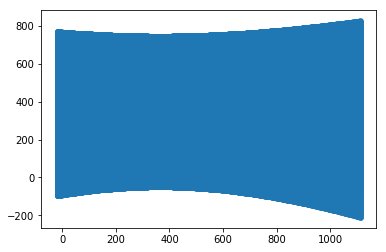

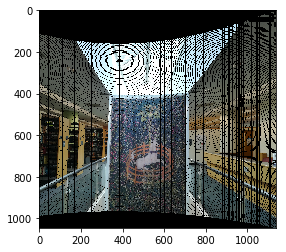

In [71]:
# theta_0=0
# phi_0=0
# K_down=K/4
# K_down[2][2]=1

# img1 = cv2.imread("spherical/img_r0c0.jpg",1)
# # img2 = cv2.imread("spherical/img_r+1c0.jpg",1)

# offset = getOffset(K_down,phi_0)

# edge = 0

# img1 = cv2.resize(img1, (0,0), fx=0.25,fy=0.25,interpolation=cv2.INTER_LINEAR)

# xmap,ymap = sphericalprojection(img1, K_down, theta_0, phi_0,offset)

# xArray = []
# yArray = []
# (h,w) = img1.shape[:2]
# xmin = w
# xmax = 0
# ymin = h
# ymax = 0


# print(xmap.shape)
# for i in range(0,h):
#     for j in range(0,w):
#         x_im = xmap[i,j]
#         y_im = ymap[i,j]
#         xArray.append(xmap[i,j])
#         yArray.append(ymap[i,j])
#         if x_im < xmin:
#             xmin = x_im
#         if x_im > xmax:
#             xmax = x_im

#         if y_im < ymin:
#             ymin = y_im
#         if y_im > ymax:
#             ymax = y_im
# print("x",xmin,xmax,"y",ymin,ymax)

# plt.figure()
# plt.plot(xArray,yArray,".")


# #=======================================
# sph_h = int(ymax)-int(ymin)+1
# sph_w = int(xmax)-int(xmin)+1
# img_sph = np.zeros((sph_h,sph_w,3))
# print(img_sph.shape)
# for i in range(0,h):
#     for j in range(0,w):
#         img_sph[int(ymap[i,j])-int(ymin),int(xmap[i,j])-int(xmin)] = img1[i,j]
        
# plt.figure()
# plt.imshow(cv2.cvtColor(img_sph.astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
# plt.show()

0
x -21.49022771367879 1115.052155164044 y -169.73033302856783 808.9634962346904


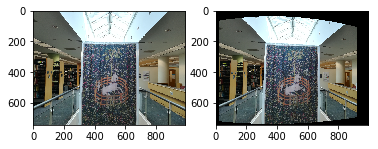

x -21.49022771367879 1115.052155164044 y -169.73033302856783 808.9634962346904


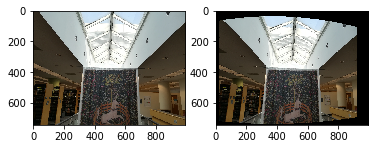

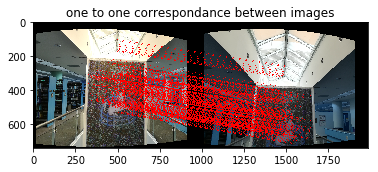

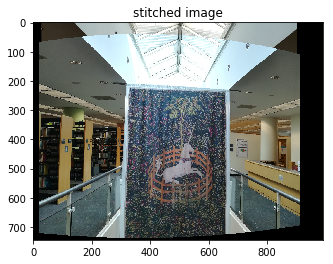

176
-9.223029388910007
x -21.49022771367879 1115.052155164044 y -169.73033302856783 808.9634962346904


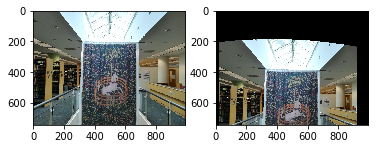

x -35.22351369254678 1196.3063013351373 y 9.800661920275033 975.0895418530566


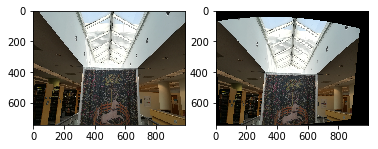

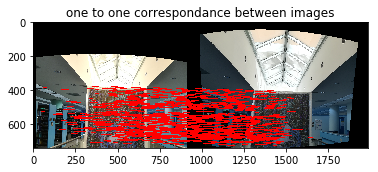

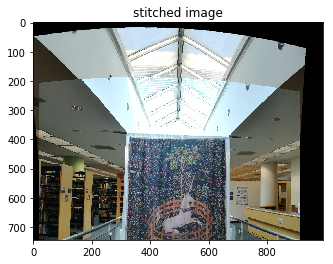

-10.693028966666985


In [48]:
theta_0=0
phi_0=0
K_down=K/4
K_down[2][2]=1

img1 = cv2.imread("spherical/img_r0c0.jpg",1)
img2 = cv2.imread("spherical/img_r+1c0.jpg",1)

offset = getOffset(K_down,phi_0)

edge = 0

sph1 = resize_SphericalWarping(img1,K_down,theta_0,phi_0,offset,edge)

# output1,theta1,phi1 = sphericalStitching(sph1,img2,K_down,theta_i,phi_i,offset)

sph2 = resize_SphericalWarping(img2,K_down,theta_0,phi_0,offset,edge)

flatOutput,affineMatrix = stitching(sph1,sph2)

theta_1,phi_1 = getThetaAndPhi(affineMatrix,theta_0,phi_0)

offset = getOffset(K_down,phi_1)

print(phi_1/math.pi*180)

sph1 = resize_SphericalWarping(img1,K_down,theta_0,phi_0,offset,edge)

sph2_rotated = resize_SphericalWarping(img2,K_down,theta_1,phi_1,offset,edge)

sphericalOutput1,affineMatrix = stitching(sph1,sph2_rotated)

theta_2,phi_2 = getThetaAndPhi(affineMatrix,theta_1,phi_1)

print(phi_2/math.pi*180)

305


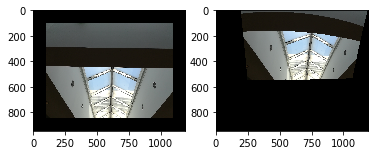

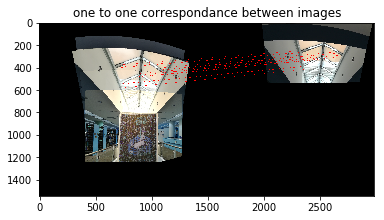

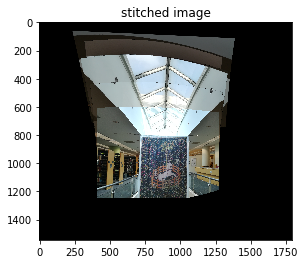

-15.031470701544668


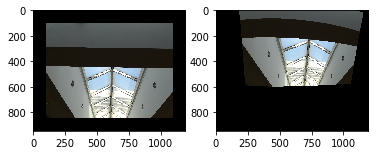

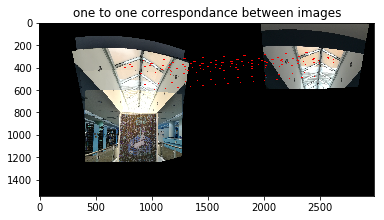

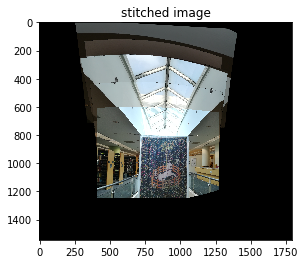

-16.84546539110317


In [35]:



output1 = sphericalOutput1
phi_2 = phi_2
offset = getOffset(K_down,phi_2)

img3 = cv2.imread("spherical/img_r+2c0.jpg",1)
output1_padded = cv2.copyMakeBorder(output1,100,100,100,100,cv2.BORDER_CONSTANT)
edge = 0
output2,theta2,phi2 = sphericalStitching(output1_padded,img3,K_down,theta_2,phi_2,offset,edge)

# ======================================
offset = getOffset(K_down,phi2)

img4 = cv2.imread("spherical/img_r+3c0.jpg",1)
output2_padded = cv2.copyMakeBorder(output2,100,100,100,100,cv2.BORDER_CONSTANT)

edge =200
output3,theta3,phi3 = sphericalStitching(output2_padded,img4,K_down,theta2,phi2,offset,edge)

# ====================================
offset = getOffset(K_down,phi3)

img5 = cv2.imread("spherical/img_r+4c0.jpg",1)
output3_padded = cv2.copyMakeBorder(output3,100,100,100,100,cv2.BORDER_CONSTANT)
output4,theta4,phi4 = sphericalStitching(output3_padded,img5,K_down,theta2,phi2,offset-300)


In [51]:
def sphericalWarpImage(img1, K,theta_i,phi_i,offset,edge):
    fx = K[0,0]
    fy = K[1,1]
    x_c = K[0,2]
    y_c = K[1,2]
    #padding the image 
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = int(offset+offset/3)
#     print(offset)
#     img1 = cv2.copyMakeBorder(img1,offset,0,100,100,cv2.BORDER_CONSTANT)

    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)

    

#     print(cyl_h)
#     print(cyl_w)


    flag = False
#while up_stitching, up_padding, down_stitching, down_padding

    if edge !=0:
        up_edge = offset
        down_edge = offset
        x_edge = edge
        cyl = np.zeros((im_h+2*offset,im_w+2*edge,3))
        cyl_mask = np.zeros((im_h+2*offset,im_w+2*edge,3))
        (cyl_h,cyl_w) = (im_h,im_w)
    else:
        cyl = np.zeros((im_h+int(math.fabs(offset)),im_w+2*int(math.fabs(offset)),3))
        cyl_mask = np.zeros((im_h+int(math.fabs(offset)),im_w+2*int(math.fabs(offset)),3))
        (cyl_h,cyl_w) = (im_h,im_w)
        if offset>0:
            up_edge = offset
            down_edge = 0
            x_edge = offset
        else:
            offset = -offset
            up_edge = 0
            down_edge = offset
            x_edge = offset
    
    print(cyl.shape)   
    
    for y_cyl in np.arange(-up_edge,im_h+down_edge):    #row
        for x_cyl in np.arange(-x_edge,im_w+x_edge):   #column
            theta = (x_cyl - x_c) / fx
            phi     =( y_cyl - y_c) / fy
    
            X = np.array([math.sin(theta)*math.cos(phi), math.sin(phi), math.cos(theta)*math.cos(phi)])
                
#             if (phi+phi_i)>(math.pi/2) or (phi + phi_i)<(-math.pi/2) :
#                 continue
                
            M1 = [[1,0,0],
                  [0, math.cos(phi_i), -math.sin(phi_i)],
                  [0, math.sin(phi_i), math.cos(phi_i)]]
            M2 = [[math.cos(theta_i), 0, math.sin(theta_i)],
                  [0,1,0],
                  [-math.sin(theta_i), 0, math.cos(theta_i)]]
            R = np.dot(M1,M2)
            X = np.dot(R,X)
            X = np.dot(K,X)
            
            
            x_im = X[0] / X[2]
            if int(x_im) < 0 or int(x_im) >= im_w:
                continue
            y_im = X[1] / X[2]
            if int(y_im) < 0 or int(y_im) >= im_h:
                continue
                
                
            if up_edge==0:
                cyl[int(y_cyl),int(x_cyl)+offset] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl),int(x_cyl)+offset] = 1
            elif down_edge == 0:
                cyl[int(y_cyl)+offset,int(x_cyl)+offset] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl)+offset,int(x_cyl)+offset] = 1
            else:
                cyl[int(y_cyl)+offset,int(x_cyl)+edge] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl)+offset,int(x_cyl)+edge] = 1
        
        
        if cyl[int(y_cyl),:].all() != 0:
            flag = True
            
        if flag :
            if cyl[int(y_cyl),:].all() != 0:
                break
                
                
#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')
    cyl_mask=cyl_mask.astype(np.uint8)
    
    return (cyl,cyl_mask)


In [21]:
def resize_SphericalWarping(img1,K_down,theta_i,phi_i,offset,edge):


    img1 = cv2.resize(img1, (0,0), fx=0.25,fy=0.25,interpolation=cv2.INTER_LINEAR)
#     img1 = cv2.copyMakeBorder(img1,edge,edge,edge,edge,cv2.BORDER_CONSTANT)

    sph1,mask1 = sphericalWarpImage(img1, K_down, theta_i, phi_i,offset,edge)
    
    sph1 = sph1.astype(np.uint8)
#     edge = 100
#     sph1 = cv2.copyMakeBorder(sph1,edge,edge,edge,edge, cv2.BORDER_CONSTANT)

    showImages(img1,sph1)
    return sph1,mask1

In [14]:
def getThetaAndPhi(affineMatrix,theta_i,phi_i):
    # print(affineMatrix)
    Tx = affineMatrix[0][2]
    Ty = affineMatrix[1][2]
    theta_i =Tx/K_down[0][0]           #+ Tx/K_down[0][0]
    phi_i = Ty/K_down[1][1]
    
    return theta_i,phi_i

In [15]:
def getOffset(K_down,phi_i):
    fx = K_down[0,0]
    fy = K_down[1,1]
    x_c = K_down[0,2]
    y_c = K_down[1,2]
    # compute the offset, apply the offset to both picture
    offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
    offset = int(offset+offset/3)
    print("offset= ",offset)
    return offset

In [16]:
def verticalStitching(img2,img1,output1,theta1,phi1,K_down,upFlag):
    
    offset = int(upFlag)*getOffset(K_down,phi1)
    
#     img2 = cv2.imread("spherical/img_r+2c0.jpg",1)
    edge = 0

    sph1 = resize_SphericalWarping(img1,K_down,theta1,phi1,offset,edge)

    output,theta2_1,phi2_1 = twoImage(sph1,img2,K_down,theta1,phi1,offset,edge)

    theta2 = theta1 + theta2_1
    phi2 = phi1 + phi2_1
    offset = int(upFlag)*getOffset(K_down,phi2)

    output2,theta2_2,phi2_2 = twoImage(output1,img2,K_down,theta2,phi2,offset,edge)
    return output2, theta2, phi2

In [53]:
cv2.imwrite('output.png',output1)

# plt.imshow(cv2.cvtColor(output_i, cv2.COLOR_BGR2RGB))
# plt.savefig("output.png",bbox_inches='tight')

True

In [49]:
def twoImage(sph1,img2,K_down,theta_i,phi_i,offset,edge):
        
    sph2_rotated,sph2_mask = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset,edge)
  
    plt.figure()
    plt.imshow(cv2.cvtColor((sph2_mask*255).astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()
    
    result,affineMatrix = stitching(sph1,sph2_rotated)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()
    
    mask = cv2.warpAffine(sph2_mask, affineMatrix, (sph1.shape[1],sph1.shape[0]))
    
    plt.figure()
    plt.imshow(cv2.cvtColor((mask*255).astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()
    
    output = Laplacian_blending(result,sph1,mask,levels=4)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(output.astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()

    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print("theta",theta_i/math.pi*180,"phi",phi_i/math.pi*180)
    #=======================================
#     sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset+200)

#     sphericalOutput2,affineMatrix = stitching(sph1,sph2_rotated)
    
#     theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
#     print(phi_i/math.pi*180)

    return output, theta_i,phi_i


In [27]:
def stitching(c1,c2):

    
    gray1= cv2.cvtColor(c1,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(c2,cv2.COLOR_BGR2GRAY)


    sift = cv2.xfeatures2d.SIFT_create()

    ################################################ TODO ###############################################
    # use sift.detect to detect features in the images
    kp1 = sift.detect(gray1,None)
    kp2 = sift.detect(gray2,None)

    img1_kps = cv2.drawKeypoints(gray1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kps = cv2.drawKeypoints(gray2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    ################################################ TODO ###############################################
    # use sift.compute to generate sift descriptors
    (kp1, features1) = sift.compute(gray1,kp1)
    (kp2, features2) = sift.compute(gray2,kp2)


    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])

    matcher = cv2.DescriptorMatcher_create("BruteForce")
    ################################################ TODO ###############################################
    # use knnMatch function in matcher to find corresonding features
    rawMatches = matcher.knnMatch(features1,features2,k=2)
    matches = []

    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        ################################################ TODO ###############################################
        if len(m) == 2 and m[0].distance<0.7*m[1].distance: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # print(matches)

    ptsA = np.float32([kp1[i] for (_,i) in matches])
    ptsB = np.float32([kp2[i] for (i,_) in matches])

    # print(ptsA)
    ################################################ TODO ###############################################
    ############src-->ptsB, dst------>ptsA
    #affine
    (affineMatrix, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC, ransacReprojThreshold=5.0)
    result = cv2.warpAffine(c2, affineMatrix, (c1.shape[1],c1.shape[0]))
    result = result.astype(np.uint8)
    
    vis = drawMatches(c1,c2,kp1,kp2,matches,status)
    plt.figure()
    plt.imshow(vis)
    plt.title('one to one correspondance between images')
    plt.show()
    
    #homography
    # (H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC) # fill in the parameters 
    # result = cv2.warpPerspective(img2,H,(img1.shape[1] + img2.shape[1], img1.shape[0]))# fill in the arguments to warp the second image to fit the first image.
    # result[0:c1.shape[0], 0:c1.shape[1]] = c1

#     output = np.zeros(result.shape)
#     x,y = result.shape[:2]
# #     print(result.shape)
#     for i in range(x):
#         for j in range(y):
#             if c1[i][j].all()== 0 and result[i][j].all()==0:
#                 output[i][j]=[0,0,0]
#             elif c1[i][j].all()==0 and result[i][j].all()!=0:
#                 output[i][j] = result[i][j]
#             elif result[i][j].all()==0 and c1[i][j].all()!=0:
#                 output[i][j] = c1[i][j]
#             else:
#                 output[i][j] = c1[i][j]
                
                
                
#                 output[i][j][0]= (int(int(c1[i][j][0]) + int(result[i][j][0]))/2) 
#                 output[i][j][1]= (int(int(c1[i][j][1]) + int(result[i][j][1]))/2) 
#                 output[i][j][2]= (int(int(c1[i][j][2]) + int(result[i][j][2]))/2) 

#     output= output.astype(np.uint8)




#     plt.figure()
#     plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
#     plt.title('stitched image')
#     plt.show()

    return result,affineMatrix

In [36]:
def Laplacian_blending(img1,img2,mask,levels=4):

    G1 = img1.copy()
    G2 = img2.copy()
    GM = mask.copy()
    gp1 = [G1]
    gp2 = [G2]
    gpM = [GM]
    for i in range(levels):
        G1 = cv2.pyrDown(G1)
        G2 = cv2.pyrDown(G2)
        GM = cv2.pyrDown(GM)
        gp1.append(np.float32(G1))
        gp2.append(np.float32(G2))
        gpM.append(np.float32(GM))

    # generate Laplacian Pyramids for A,B and masks
    lp1  = [gp1[levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lp2  = [gp2[levels-1]]
    gpMr = [gpM[levels-1]]
    for i in range(levels-1,0,-1):
        # Laplacian: subtarct upscaled version of lower level from current level
        # to get the high frequencies
        L1 = np.subtract(gp1[i-1], cv2.pyrUp(gp1[i]))
        L2 = np.subtract(gp2[i-1], cv2.pyrUp(gp2[i]))
        lp1.append(L1)
        lp2.append(L2)
        gpMr.append(gpM[i-1]) # also reverse the masks
            
            # Now blend images according to mask in each level
    LS = []
    for l1,l2,gm in zip(lp1,lp2,gpMr):
        ls = l1 * gm + l2 * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,levels):
        ls_ = cv2.pyrUp(ls_)
        ls_ = np.add(ls_, LS[i])

    return ls_

offset=  0
(744, 992, 3)


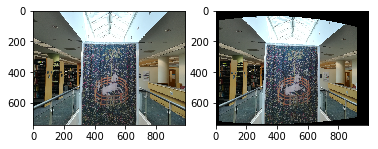

(2744, 1992, 3)


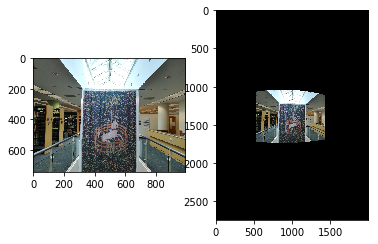

(744, 992, 3)


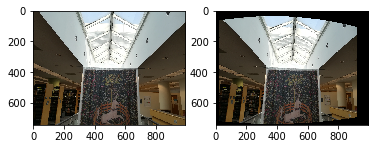

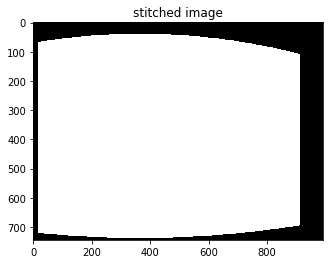

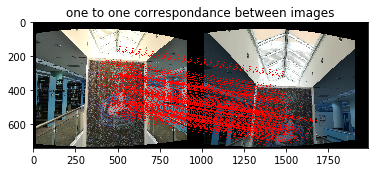

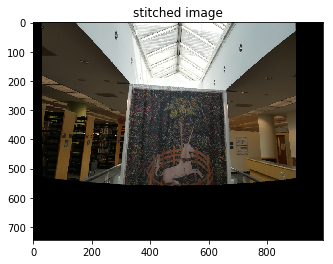

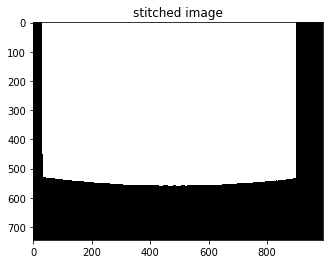

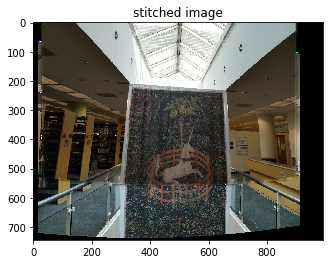

theta 0.715164854875362 phi -9.55963022901213
offset=  183
(927, 1358, 3)


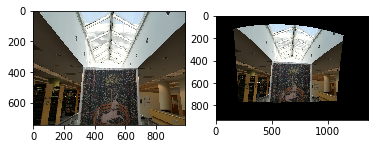

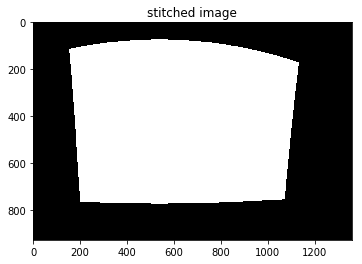

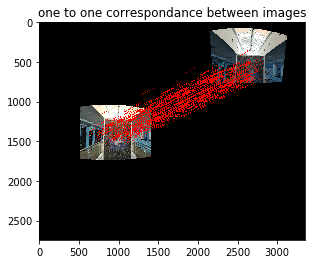

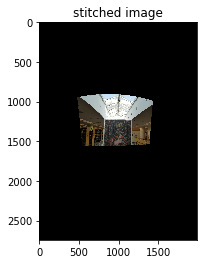

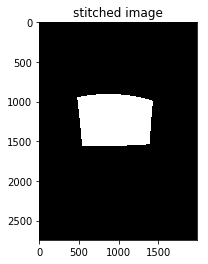

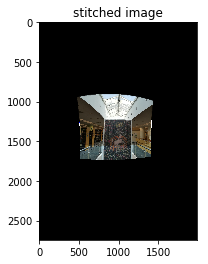

theta 20.82205839592373 phi 54.08414221419932


In [52]:

K_down=K/4
K_down[2][2]=1

theta1_0=0
phi1_0=0

img0 = cv2.imread("spherical/img_r0c0.jpg",1)
img1 = cv2.imread("spherical/img_r+1c0.jpg",1)

edge = 0
offset = getOffset(K_down,phi1_0)

sph0,mask0 = resize_SphericalWarping(img0,K_down,theta1_0,phi1_0,offset,edge)
output,mask = resize_SphericalWarping(img0,K_down,theta1_0,phi1_0,1000,500)


# sph1_padded = cv2.copyMakeBorder(sph1,100,100,100,100,cv2.BORDER_CONSTANT)
output0,theta1_1,phi1_1 = twoImage(sph0,img1,K_down,theta1_0,phi1_0,offset,edge)

theta1 = theta1_0+theta1_1
phi1 = phi1_0+phi1_1

offset = getOffset(K_down,phi1_1)

output1,theta1_2,phi1_2 = twoImage(output,img1,K_down,theta1,phi1,offset,edge)


176


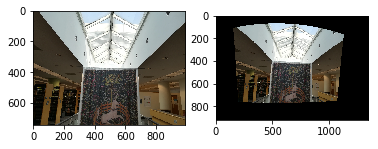

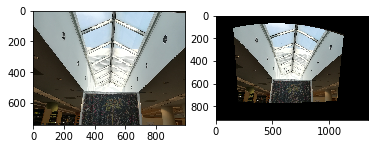

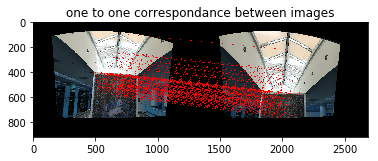

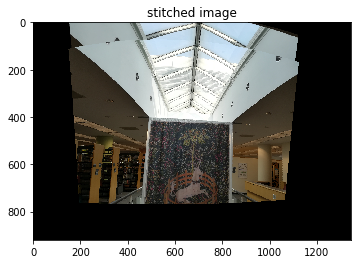

theta 0.14198755917825248 phi -8.031153363749397
330


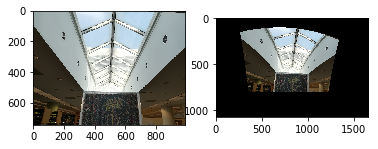

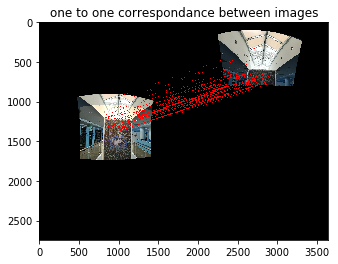

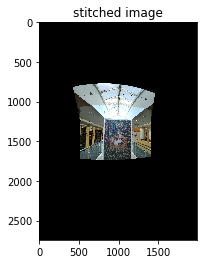

theta 10.424923098538805 phi 43.468799789512985


In [160]:

offset = getOffset(K_down,phi1_1)

img2 = cv2.imread("spherical/img_r+2c0.jpg",1)
# output1_padded = cv2.copyMakeBorder(output1,100,100,100,100,cv2.BORDER_CONSTANT)
edge = 0

sph1 = resize_SphericalWarping(img1,K_down,theta1,phi1,offset,edge)

# sph1_padded = cv2.copyMakeBorder(sph1,100,100,100,100,cv2.BORDER_CONSTANT)

output,theta2_1,phi2_1 = twoImage(sph1,img2,K_down,theta1,phi1,offset,edge)

theta2 = theta1 + theta2_1
phi2 = phi1 + phi2_1
offset = getOffset(K_down,phi2)


output2,theta2_2,phi2_2 = twoImage(output1,img2,K_down,theta2,phi2,offset,edge)

330


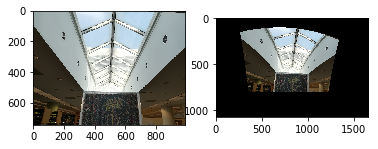

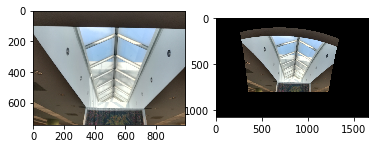

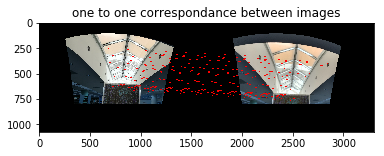

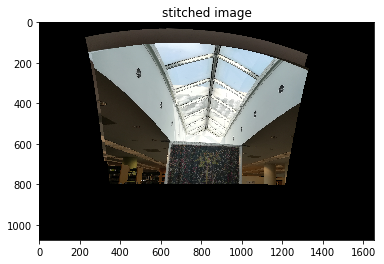

theta -2.2537674258544533 phi -4.763224775706669
422


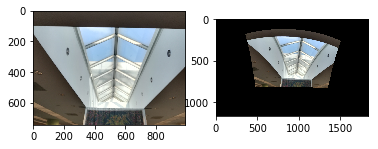

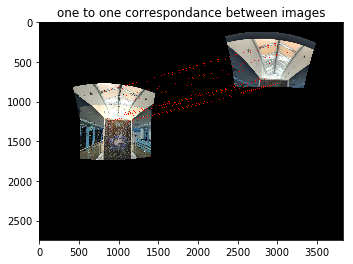

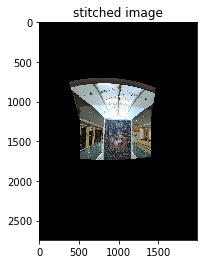

theta 1.6591638362311687 phi 38.22768767887131


In [162]:

offset = getOffset(K_down,phi2)

img3 = cv2.imread("spherical/img_r+3c0.jpg",1)
# output1_padded = cv2.copyMakeBorder(output1,100,100,100,100,cv2.BORDER_CONSTANT)
edge = 0

sph2 = resize_SphericalWarping(img2,K_down,theta2,phi2,offset,edge)

# sph1_padded = cv2.copyMakeBorder(sph1,100,100,100,100,cv2.BORDER_CONSTANT)

output,theta3_1,phi3_1 = twoImage(sph2,img3,K_down,theta2,phi2,offset,edge)

theta3 = theta2 + theta3_1
phi3 = phi2 + phi3_1
offset = getOffset(K_down,phi3)


output3,theta3_2,phi3_2 = twoImage(output2,img3,K_down,theta3,phi3,offset,edge)

422


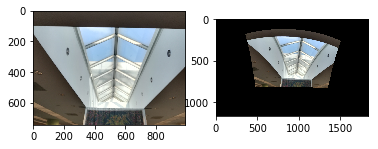

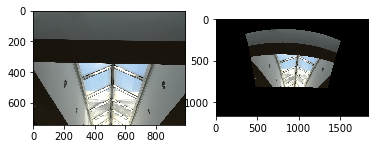

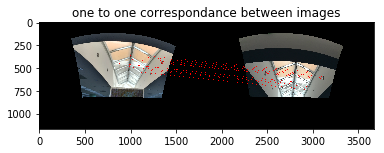

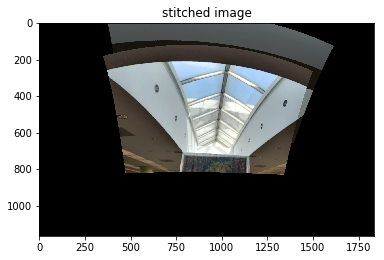

theta 0.14707391142388573 phi -14.206975931006443
694


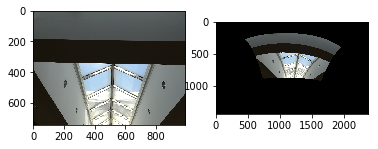

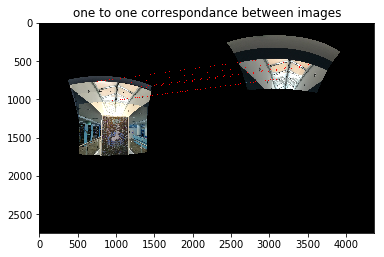

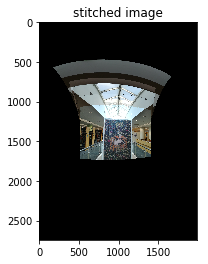

theta -19.44942001392032 phi 19.97310107034805


In [171]:

offset = getOffset(K_down,phi3)

img4 = cv2.imread("spherical/img_r+4c0.jpg",1)
# output1_padded = cv2.copyMakeBorder(output1,100,100,100,100,cv2.BORDER_CONSTANT)
edge = 0

sph3 = resize_SphericalWarping(img3,K_down,theta3,phi3,offset,edge)

# sph1_padded = cv2.copyMakeBorder(sph1,100,100,100,100,cv2.BORDER_CONSTANT)

output,theta4_1,phi4_1 = twoImage(sph3,img4,K_down,theta3,phi3,offset,edge)

theta4 = theta3 + theta4_1
phi4 = phi3 + phi4_1
offset = getOffset(K_down,phi4)


output4,theta4_2,phi4_2 = twoImage(output3,img4,K_down,theta4,phi4,offset,edge)

694


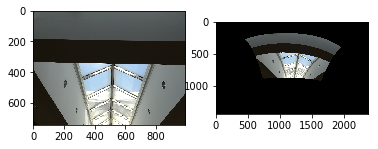

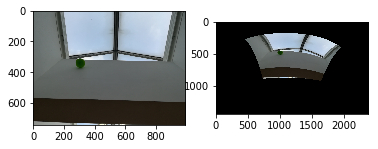

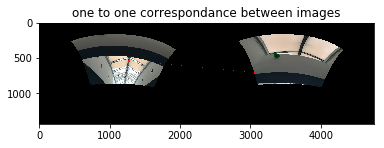

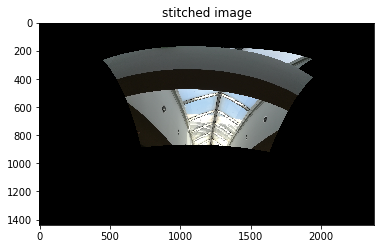

theta 0.20901757475569957 phi 9.501278285770676
512


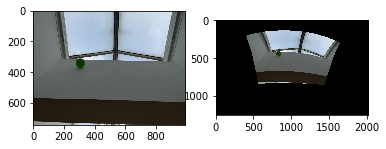

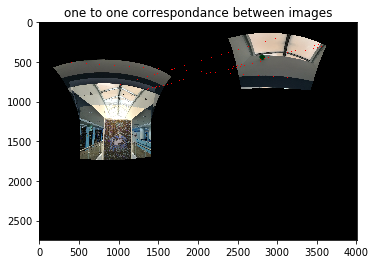

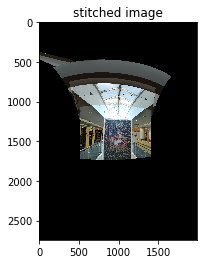

theta 12.811330751125453 phi 40.781748495108175


In [172]:

offset = getOffset(K_down,phi4)

img5 = cv2.imread("spherical/img_r+5c0.jpg",1)
# output1_padded = cv2.copyMakeBorder(output1,100,100,100,100,cv2.BORDER_CONSTANT)
edge = 0

sph4 = resize_SphericalWarping(img4,K_down,theta4,phi4,offset,edge)

# sph1_padded = cv2.copyMakeBorder(sph1,100,100,100,100,cv2.BORDER_CONSTANT)

output,theta5_1,phi5_1 = twoImage(sph4,img5,K_down,theta4,phi4,offset,edge)

theta5 = theta4 + theta5_1
phi5 = phi4 + phi5_1
offset = getOffset(K_down,phi5)


output5,theta5_2,phi5_2 = twoImage(output4,img5,K_down,theta5,phi5,offset,edge)

0
(744, 992, 3)


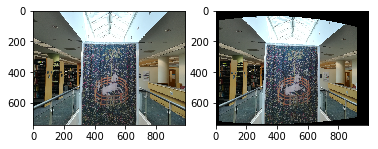

(744, 992, 3)


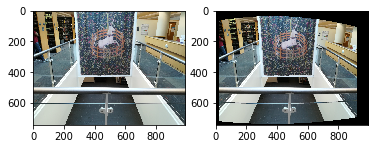

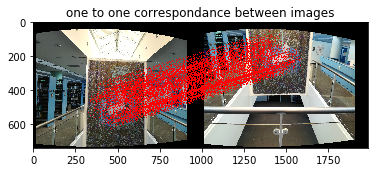

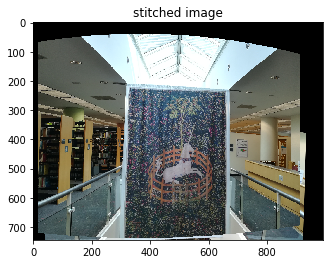

theta 2.3633021428230405 phi 18.86478995404851
361
(1105, 1714, 3)


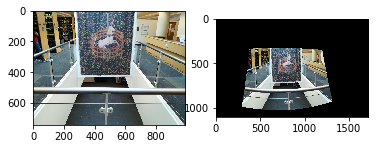

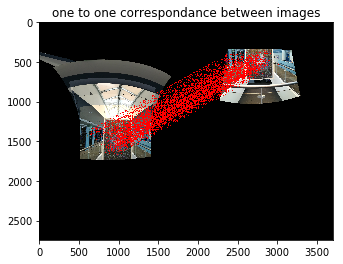

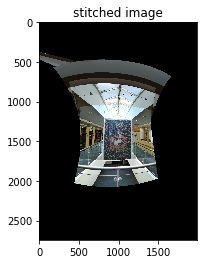

theta 13.055834136605423 phi 61.597060950956546


In [209]:
theta1_0=0
phi1_0=0
K_down=K/4
K_down[2][2]=1

img0 = cv2.imread("spherical/img_r0c0.jpg",1)
img1 = cv2.imread("spherical/img_r-1c0.jpg",1)

edge = 0
offset = getOffset(K_down,phi1_0)

sph0 = resize_SphericalWarping(img0,K_down,theta1_0,phi1_0,offset,edge)

# sph1_padded = cv2.copyMakeBorder(sph1,100,100,100,100,cv2.BORDER_CONSTANT)
output0,theta1_1,phi1_1 = twoImage(sph0,img1,K_down,theta1_0,phi1_0,offset,edge)

theta1 = theta1_0+theta1_1
phi1 = phi1_0+phi1_1

offset = -getOffset(K_down,phi1)

output6,theta1_2,phi1_2 = twoImage(output5,img1,K_down,theta1,phi1,offset,edge)


In [205]:
print(phi1)

0.32925269739529633
